In [1]:
!pip install --quiet ftfy regex tqdm
!pip install --quiet git+https://github.com/openai/CLIP.git
!pip install --quiet pycocotools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Download and Prepare the MS COCO Dataset

In [2]:
import os
import requests
from zipfile import ZipFile
from tqdm import tqdm

# Define paths
data_dir = '/content/coco2014'
os.makedirs(data_dir, exist_ok=True)

# URLs for datasets and annotations
datasets = {
    "train2014": "http://images.cocodataset.org/zips/train2014.zip",
    "val2014": "http://images.cocodataset.org/zips/val2014.zip",
    "annotations_trainval2014": "http://images.cocodataset.org/annotations/annotations_trainval2014.zip",
}

# Download helper function with progress bar
def download_file(url, dest_path):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    with open(dest_path, 'wb') as f, tqdm(
        desc=f"Downloading {os.path.basename(dest_path)}",
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            f.write(data)
            bar.update(len(data))

# Download and extract datasets
for name, url in datasets.items():
    zip_path = os.path.join(data_dir, f"{name}.zip")
    print(f"Processing {name}...")

    # Download the dataset
    download_file(url, zip_path)

    # Unzip the dataset
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)

    # Remove the zip file to save space
    os.remove(zip_path)
    print(f"{name} downloaded and extracted.")

print("All datasets and annotations successfully downloaded and extracted!")


Processing train2014...


KeyboardInterrupt: 

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths
gdrive_dir = '/content/drive/MyDrive/coco2014'  # Google Drive directory
data_dir = '/content/coco2014'
os.makedirs(data_dir, exist_ok=True)

# Dataset names
data = ["train2014", "val2014", "annotations_trainval2014"]

# Extract datasets from Google Drive
for name in data:
    zip_path = os.path.join(gdrive_dir, f"{name}.zip")
    print(f"Processing {name}...")

    if os.path.exists(zip_path):
        # Unzip the dataset to the local directory
        with ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        print(f"{name} extracted to local directory.")
    else:
        print(f"Zip file for {name} not found in Google Drive at {zip_path}.")

print("All available datasets successfully extracted to local directory!")

Mounted at /content/drive
Processing train2014...
train2014 extracted to local directory.
Processing val2014...
val2014 extracted to local directory.
Processing annotations_trainval2014...
annotations_trainval2014 extracted to local directory.
All available datasets successfully extracted to local directory!


# Load the Teacher Model: CLIP RN50 Model

In [5]:
import torch
import clip
import numpy as np


device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Load the CLIP model
model, preprocess = clip.load("RN50", device)
model.eval()

input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)


100%|███████████████████████████████████████| 244M/244M [00:03<00:00, 81.2MiB/s]


Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


# Define the Student Model (ResNet-34)

In [6]:
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F


# Student Image Encoder (ResNet-34)
class StudentImageEncoder(nn.Module):
    def __init__(self, output_dim):
        super(StudentImageEncoder, self).__init__()
        self.encoder = models.resnet34(pretrained=False)
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features, output_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x / x.norm(dim=-1, keepdim=True)  # Normalize
        return x


class StudentTextEncoder(nn.Module):
    def __init__(self, vocab_size, context_length, output_dim):
        super(StudentTextEncoder, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, output_dim)
        self.positional_embedding = nn.Parameter(torch.zeros(context_length, output_dim))
        nn.init.normal_(self.positional_embedding, std=0.01)
        encoder_layer = nn.TransformerEncoderLayer(d_model=output_dim, nhead=8)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.ln_final = nn.LayerNorm(output_dim)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        x = self.token_embedding(x) + self.positional_embedding  # (batch_size, seq_len, output_dim)
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, output_dim)
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # (batch_size, seq_len, output_dim)
        x = self.ln_final(x)
        x = x.mean(dim=1)  # Mean pooling over the sequence length
        x = x / x.norm(dim=-1, keepdim=True)  # Normalize to unit length
        return x  # (batch_size, output_dim)



# Prepare the MSCOCO Data Loaders

In [7]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset

# Preprocessing transforms
transform = transforms.Compose([
    transforms.Resize((input_resolution, input_resolution)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                         std=(0.26862954, 0.26130258, 0.27577711))
])

# Custom dataset to select one caption per image
class CocoDataset(Dataset):
    def __init__(self, root, annFile, transform=None):
        self.dataset = datasets.CocoCaptions(root=root, annFile=annFile, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, captions = self.dataset[idx]
        # Select the first caption
        caption = captions[0]
        # Tokenize the caption
        text = clip.tokenize(caption, context_length=context_length)[0]
        return image, text

# Paths to images and annotations
train_img_dir = os.path.join(data_dir, 'train2014')
train_ann_file = os.path.join(data_dir, 'annotations', 'captions_train2014.json')

# Create the training dataset and dataloader
train_dataset = CocoDataset(root=train_img_dir, annFile=train_ann_file, transform=transform)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=64,  # batch size
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


# Define the Contrastive Loss Function Using Logit + KL + MSE + Synergy + Redundancy

In [8]:
import torch
import torch.nn.functional as F
import torch.nn as nn

def compute_redundancy(student_image_features, student_text_features,
                       teacher_image_features, teacher_text_features):
    # Normalize
    s_i = F.normalize(student_image_features, dim=-1)
    s_t = F.normalize(student_text_features, dim=-1)
    t_i = F.normalize(teacher_image_features, dim=-1)
    t_t = F.normalize(teacher_text_features, dim=-1)

    # Approximate redundancy as the average similarity of corresponding modalities
    img_similarity = (s_i * t_i).sum(dim=-1).mean()  # dot product similarity
    txt_similarity = (s_t * t_t).sum(dim=-1).mean()
    redundancy = (img_similarity + txt_similarity) / 2.0
    return redundancy

def compute_synergy(img_features_1, txt_features_1, img_features_2, txt_features_2):
    # Compute synergy between two sets of features (e.g., student and teacher)
    # Normalize
    f1_i = F.normalize(img_features_1, dim=-1)
    f1_t = F.normalize(txt_features_1, dim=-1)
    f2_i = F.normalize(img_features_2, dim=-1)
    f2_t = F.normalize(txt_features_2, dim=-1)

    # Joint embeddings (concatenate image and text)
    joint_1 = torch.cat([f1_i, f1_t], dim=-1)
    joint_2 = torch.cat([f2_i, f2_t], dim=-1)

    def avg_cosine(u, v):
        return (u * v).sum(dim=-1).mean()

    joint_similarity = avg_cosine(joint_1, joint_2)
    img_similarity = avg_cosine(f1_i, f2_i)
    txt_similarity = avg_cosine(f1_t, f2_t)

    # Synergy heuristic: joint similarity minus the average of separate similarities
    synergy = joint_similarity - (img_similarity + txt_similarity) / 2.0
    return synergy


In [9]:
def contrastive_loss_with_kl_l2_pid(
    student_image_features,
    student_text_features,
    teacher_image_features,
    teacher_text_features,
    temperature=0.07,
    alpha=1.0,  # weight for KL term
    beta=0.3,   # weight for L2 term
    gamma=0.7,  # weight for synergy rewards
    epsilon=0.5  # weight for redundancy maximization
):
    """
    Compute a combined loss:
    - Contrastive loss for image-text alignment,
    - KL-divergence to match student distributions with teacher distributions,
    - L2 distance (feature-level distillation),
    - PID-inspired terms: maximize synergy,
    - Redundancy maximization: maximize alignment between teacher and student modalities.

    Args:
        student_image_features: (batch_size, embed_dim)
        student_text_features: (batch_size, embed_dim)
        teacher_image_features: (batch_size, embed_dim)
        teacher_text_features: (batch_size, embed_dim)
        temperature: Temperature for scaling logits (default=0.07).
        alpha: Weight for the KL-divergence loss.
        beta: Weight for the L2 distance loss.
        gamma: Weight for the synergy rewards (student-teacher synergy).
        epsilon: Weight for the redundancy maximization loss.

    Returns:
        total_loss: Combined loss value.
    """

    # Normalize features
    student_image_features = student_image_features / student_image_features.norm(dim=-1, keepdim=True)
    student_text_features = student_text_features / student_text_features.norm(dim=-1, keepdim=True)
    teacher_image_features = teacher_image_features / teacher_image_features.norm(dim=-1, keepdim=True)
    teacher_text_features = teacher_text_features / teacher_text_features.norm(dim=-1, keepdim=True)

    # Compute student logits
    logits_per_image_student = student_image_features @ student_text_features.t() / temperature
    logits_per_text_student = logits_per_image_student.t()

    # Compute teacher logits (no gradients)
    with torch.no_grad():
        logits_per_image_teacher = teacher_image_features @ teacher_text_features.t() / temperature
        logits_per_text_teacher = logits_per_image_teacher.t()

    # Contrastive loss
    batch_size = student_image_features.size(0)
    labels = torch.arange(batch_size, device=student_image_features.device)
    loss_image = F.cross_entropy(logits_per_image_student, labels)
    loss_text = F.cross_entropy(logits_per_text_student, labels)
    contrastive_loss = (loss_image + loss_text) / 2

    # KL-divergence loss
    student_img_log_probs = F.log_softmax(logits_per_image_student, dim=-1)
    teacher_img_probs = F.softmax(logits_per_image_teacher, dim=-1)
    kl_img = F.kl_div(student_img_log_probs, teacher_img_probs, reduction='batchmean')

    student_txt_log_probs = F.log_softmax(logits_per_text_student, dim=-1)
    teacher_txt_probs = F.softmax(logits_per_text_teacher, dim=-1)
    kl_txt = F.kl_div(student_txt_log_probs, teacher_txt_probs, reduction='batchmean')

    kl_loss = (kl_img + kl_txt) / 2

    # L2 distance loss
    l2_img = F.mse_loss(student_image_features, teacher_image_features)
    l2_txt = F.mse_loss(student_text_features, teacher_text_features)
    l2_loss = (l2_img + l2_txt) / 2

    # Compute synergy between student and teacher
    synergy = compute_synergy(student_image_features, student_text_features,
                              teacher_image_features, teacher_text_features)

    # Compute redundancy
    redundancy = compute_redundancy(student_image_features, student_text_features,
                                    teacher_image_features, teacher_text_features)

    # Combine all losses
    # Increase synergy by subtracting gamma * synergy
    # Maximize redundancy by subtracting epsilon * redundancy
    total_loss = (contrastive_loss + alpha * kl_loss + beta * l2_loss - gamma * synergy  - epsilon * redundancy)

    return total_loss


# Set Up the Training Loop

In [10]:
# Instantiate student models
student_image_encoder = StudentImageEncoder(output_dim=1024).to(device)
student_text_encoder = StudentTextEncoder(vocab_size, context_length, output_dim=1024).to(device)

# Define optimizer
optimizer = torch.optim.Adam(
    list(student_image_encoder.parameters()) + list(student_text_encoder.parameters()),
    lr=1e-4
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


# Train the Student Model

In [14]:
# Training Loop with batch-wise memory clearing
num_epochs = 40  # Number of epochs

for epoch in range(num_epochs):
    student_image_encoder.train()
    student_text_encoder.train()
    total_loss = 0.0

    for batch_idx, (images, texts) in enumerate(train_dataloader):
        images = images.to(device)
        texts = texts.to(device)

        # Teacher outputs
        with torch.no_grad():
            teacher_image_features = model.encode_image(images)
            teacher_text_features = model.encode_text(texts)

        # Student outputs
        student_image_features = student_image_encoder(images).to(teacher_image_features.dtype)
        student_text_features = student_text_encoder(texts).to(teacher_text_features.dtype)

        # Compute Contrastive Loss with detailed returns
        loss = contrastive_loss_with_kl_l2_pid(
            student_image_features,
            student_text_features,
            teacher_image_features,
            teacher_text_features
        )

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Clear batch-related memory
        del images, texts, teacher_image_features, teacher_text_features
        del student_image_features, student_text_features
        torch.cuda.empty_cache()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")


Epoch [1/1], Average Loss: 1.5463


# Evaluate the Trained Student Model

In [27]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import clip
import os
import numpy as np
from torch.utils.data import Subset

device = "cuda" if torch.cuda.is_available() else "cpu"
input_resolution = 224
context_length = 77

# Evaluation transforms (same as training)
eval_transform = transforms.Compose([
    transforms.Resize((input_resolution, input_resolution)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                         std=(0.26862954, 0.26130258, 0.27577711))
])

class CocoEvalDataset(Dataset):
    def __init__(self, root, annFile, transform=None):
        self.dataset = datasets.CocoCaptions(root=root, annFile=annFile, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, captions = self.dataset[idx]
        # Return the full list of captions for each image
        return image, captions

def coco_collate_fn(batch):
    # batch is a list of (image, captions_list) tuples
    images = []
    captions = []
    for img, caps in batch:
        images.append(img)      # img is a Tensor
        captions.append(caps)   # caps is a list of strings
    images = torch.stack(images, dim=0)  # stack all images into a single tensor
    return images, captions


# Paths for validation
val_img_dir = os.path.join(data_dir, 'val2014')
val_ann_file = os.path.join(data_dir, 'annotations', 'captions_val2014.json')



val_dataset = CocoEvalDataset(root=val_img_dir, annFile=val_ann_file, transform=eval_transform)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, collate_fn=coco_collate_fn)


# Limit validation dataset to 5000 images
subset_indices = list(range(5000))  # change to how many validation you want
val_subset = Subset(val_dataset, subset_indices)

# Create a new DataLoader for the subset
val_subset_dataloader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=2, collate_fn=coco_collate_fn)

# Evaluation with batch-wise memory clearing
student_image_encoder.eval()
student_text_encoder.eval()

all_image_features = []
all_text_features = []
image_to_text_indices = []  # For each image, store which text indices correspond to its captions
all_captions_flat = []  # Store all captions globally

with torch.no_grad():
    for images, batch_captions in val_subset_dataloader:  # Use subset dataloader
        images = images.to(device)

        # Encode images
        image_feats = student_image_encoder(images)
        image_feats = image_feats / image_feats.norm(dim=-1, keepdim=True)
        all_image_features.append(image_feats.cpu())

        # Flatten captions for this batch
        flat_captions = []
        image_to_text_map_for_batch = []
        for caps in batch_captions:
            start_idx = len(flat_captions)
            flat_captions.extend(caps)  # Add all captions from this image
            end_idx = len(flat_captions)
            # Map indices for each image's captions
            image_to_text_map_for_batch.append(list(range(start_idx, end_idx)))

        # Tokenize captions in batch
        texts = clip.tokenize(flat_captions, context_length=context_length).to(device)
        text_feats = student_text_encoder(texts)
        text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)

        # Store text features globally
        all_text_features.append(text_feats.cpu())
        all_captions_flat.extend(flat_captions)

        # Update global mapping
        image_to_text_indices.extend(image_to_text_map_for_batch)

        # Clear batch-related memory
        del images, batch_captions, image_feats, flat_captions, texts, text_feats
        torch.cuda.empty_cache()

# Combine all features
all_image_features = torch.cat(all_image_features, dim=0)  # (N_images, embed_dim)
all_text_features = torch.cat(all_text_features, dim=0)    # (N_captions_total, embed_dim)

# Compute similarity matrix: shape (N_images, N_captions_total)
sim_matrix = all_image_features @ all_text_features.t()


def compute_recall_with_multiple_captions(sim_matrix, image_to_text_indices, k=1):
    n = sim_matrix.size(0)
    successes = 0
    for i in range(n):
        scores = sim_matrix[i]
        sorted_indices = torch.argsort(scores, descending=True)

        correct_indices = set(image_to_text_indices[i])
        ranks_of_correct = []
        for cidx in correct_indices:
            pos = (sorted_indices == cidx).nonzero(as_tuple=True)
            if len(pos) > 0:
                ranks_of_correct.append(pos[0].item())

        if len(ranks_of_correct) > 0:
            min_rank = min(ranks_of_correct)
            if min_rank < k:
                successes += 1
    recall = successes / n
    return recall

# Image-to-Text Retrieval
r1 = compute_recall_with_multiple_captions(sim_matrix, image_to_text_indices, k=1)
r5 = compute_recall_with_multiple_captions(sim_matrix, image_to_text_indices, k=5)
r10 = compute_recall_with_multiple_captions(sim_matrix, image_to_text_indices, k=10)

print("Image-to-Text Retrieval:")
print(f"Recall@1: {r1*100:.2f}%")
print(f"Recall@5: {r5*100:.2f}%")
print(f"Recall@10: {r10*100:.2f}%")

# Text-to-Image Retrieval
# Create reverse mapping from text index to image index
text_to_image = [None]*all_text_features.size(0)
for i, tinds in enumerate(image_to_text_indices):
    for t in tinds:
        text_to_image[t] = i

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
Image-to-Text Retrieval:
Recall@1: 0.14%
Recall@5: 0.28%
Recall@10: 0.42%


Image Index: 0
Top-5 Predicted Captions: ['A cat is showing its appreciation for someone in black pants and a red sweater. ', 'A large stuffed bear takes up the back seat of a motorcycle.', 'A stuffed teddy bear is fastened into a car seat.  ', 'A boy with red hair standing in front of a black and white dog.', 'Stuffed bear wearing glasses with electronic audio equipment.']
Ground Truth Captions: ['This wire metal rack holds several pairs of shoes and sandals', 'A dog sleeping on a show rack in the shoes.', 'Various slides and other footwear rest in a metal basket outdoors.', 'A small dog is curled up on top of the shoes', 'a shoe rack with some shoes and a dog sleeping on them']



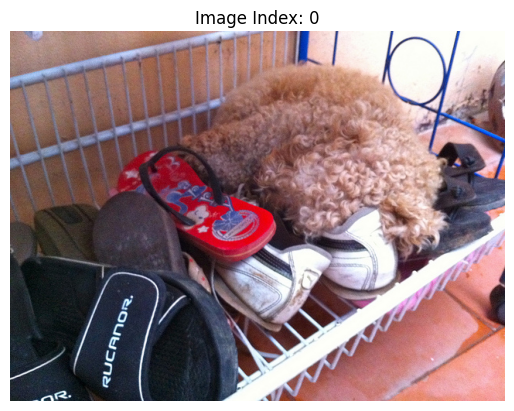

Image Index: 1
Top-5 Predicted Captions: ['black and white photo of a scooter carrying numerous bikes', 'A bicycle parked next to a motor scooter.', 'there is a old black motorcycle inside of a garage', 'A motorbike parked, with several bicycles stacked on on the back of it.', 'Small motorcycle with several bicycles tied to the back of it. ']
Ground Truth Captions: ['A motorcycle parked in a parking space next to another motorcycle.', 'An old motorcycle parked beside other motorcycles with a brown leather seat.', 'Motorcycle parked in the parking lot of asphalt.', 'A close up view of a motorized bicycle, sitting in a rack. ', 'The back tire of an old style motorcycle is resting in a metal stand. ']



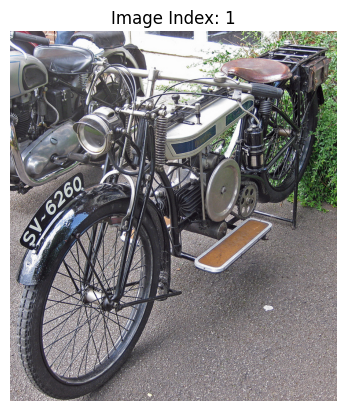

Image Index: 2
Top-5 Predicted Captions: ['A ram and another sheep standing in the snow.', 'Two sheep standing next to each other in the snow.', 'Two sheep standing in the snow while one is nosing around in it.', 'Two puffy sheep stand in the snow and one sheep has its nose to the ground.', 'Three white sheep traveling down a paved residential street.']
Ground Truth Captions: ['A picture of a dog laying on the ground.', 'Dog snoozing by a bike on the edge of a cobblestone street', 'The white dog lays next to the bicycle on the sidewalk.', 'a white dog is sleeping on a street and a bicycle', 'A puppy rests on the street next to a bicycle.']



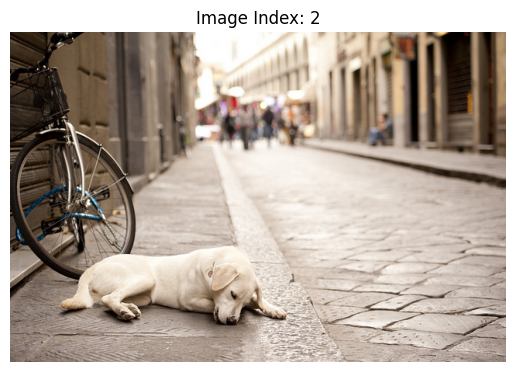

Image Index: 3
Top-5 Predicted Captions: ['A small refrigerator sitting on top of a wooden counter.', 'A twin door refrigerator in a kitchen next to cabinets.', 'A microwave oven sitting on top of a refrigerator in a kitchen.', 'Commercial refrigerator and old stove in a barn', 'A microwave sits on top of a mini fridge. ']
Ground Truth Captions: ['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']



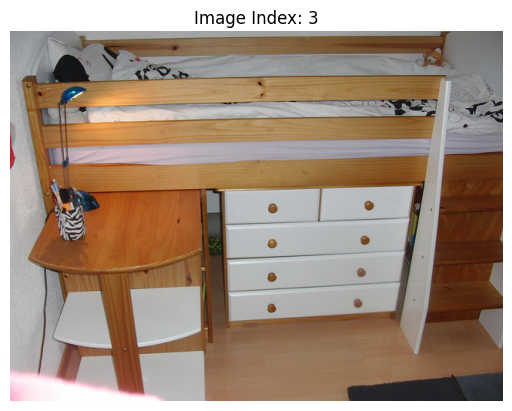

Image Index: 4
Top-5 Predicted Captions: ['A giraffe looking over a bar inside a building.', 'A large wooden clock sitting in between two pillars.', 'an old stone building with a clock mounted on the side.', 'a black and tan clock on a brown brick building', 'A zebra statue outside of a building zoomed in closely.']
Ground Truth Captions: ['Two giraffes in a room with people looking at them.', 'Two giraffe standing next to each other in a room.', 'The giraffe is being kept by itself indoors. ', 'A man and woman staring at two giraffes through a window.', 'a giraffe in a enclosed area is watched by some people']



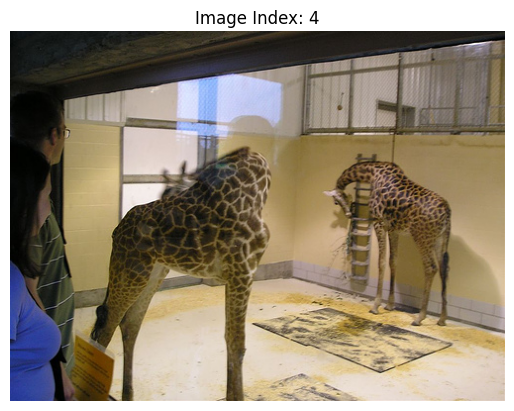

In [28]:
import matplotlib.pyplot as plt
from PIL import Image

# Define the value of k for top-k predictions
k_val = 5

# Directory to save predictions and README
output_dir = "/content/drive/MyDrive/coco2014"
os.makedirs(output_dir, exist_ok=True)

# File to save predictions and ground truth labels
predictions_file = os.path.join(output_dir, "predictions_and_labels.json")

# Collect predictions and ground truth labels
results = []

for i in range(len(image_to_text_indices)):
    scores = sim_matrix[i]  # Similarity scores for image i to all captions
    sorted_indices = torch.argsort(scores, descending=True)[:k_val]  # Top k predictions

    # Get the predicted captions
    predicted_captions = [all_captions_flat[idx] for idx in sorted_indices]

    # Get the ground truth captions for the image
    truth_indices = image_to_text_indices[i]
    truth_captions = [all_captions_flat[idx] for idx in truth_indices]

    # Store results for this image
    results.append({
        "image_index": i,
        "predicted_captions": predicted_captions,
        "truth_captions": truth_captions
    })

    # Print the top predictions and ground truth for the first few rows
    if i < 5:  # Display the first 5 rows
        print(f"Image Index: {i}")
        print(f"Top-{k_val} Predicted Captions: {predicted_captions}")
        print(f"Ground Truth Captions: {truth_captions}\n")

        # Load and preprocess the image
        image_metadata = val_dataset.dataset.coco.loadImgs(val_dataset.dataset.ids[subset_indices[i]])[0]
        image_path = os.path.join(val_img_dir, image_metadata['file_name'])
        if not os.path.exists(image_path):
            print(f"Image file not found: {image_path}")
            continue

        img = Image.open(image_path).convert("RGB")
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Image Index: {i}")
        plt.show()

# Save results to a JSON file
import json
with open(predictions_file, "w") as f:
    json.dump(results, f, indent=4)